In [1]:
# Import libraries.

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections 

from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from collections import Counter


sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Read in training and test data.

train_data = pd.read_csv("./train (1).csv")
test_data = pd.read_csv("./test.csv")

train_data.head(20)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500
5,138,535126040,20,RL,137.0,16492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,6,2010,WD,190000
6,2827,908186070,180,RM,35.0,3675,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,6,2006,New,140000
7,145,535154050,20,RL,NaN,12160,Pave,NaN,IR1,Lvl,...,0,0,NaN,MnPrv,NaN,0,5,2010,COD,142000
8,1942,535353130,20,RL,NaN,15783,Pave,NaN,Reg,Lvl,...,0,0,NaN,MnPrv,Shed,400,6,2007,WD,112500
9,1956,535426130,60,RL,70.0,11606,Pave,NaN,IR1,HLS,...,0,0,NaN,NaN,NaN,0,9,2007,WD,135000


In [3]:
# Concatenate training and test data files for data cleaning.

all_data = train_data.append(test_data, ignore_index=True, sort = False)

In [4]:
# Create list with number of NaNs for each column
num_nas = [len(all_data[[column]])-all_data[column].count() for column in all_data.columns]

In [5]:
# Data cleaning: Replace NaN values with 0.

all_data = all_data.fillna(0)

In [6]:
# Column info: all looks good

all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 81 columns):
Id                 2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2930 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              2930 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         2

In [7]:
# Create a dataframe with that lists the number of unique values and type for each column.

column_names = all_data.columns.tolist()
unique_count = [len(all_data[column].unique()) for column in all_data.columns]
types = all_data.dtypes.values.tolist()
make_dummy = [False for column in all_data.columns]
standardize = [False for column in all_data.columns]

column_info = pd.DataFrame({"column": column_names, 
                            "unique_count": unique_count, 
                            "num_nas": num_nas, 
                            "dtype": types, 
                            "make_dummy": make_dummy, 
                            "standardize": standardize})

#Make dummy columns for all non-numical columns and numeric columns with less than 10 unique values.
#Standardize all other columns.

column_info["make_dummy"] = (column_info["unique_count"] < 10) | (column_info["dtype"] == "object")
column_info["standardize"] = column_info["make_dummy"] == False

# Make sure SalePrice and Id do not get dummied or standardized

column_info.loc[80,'make_dummy'] = False
column_info.loc[80,'standardize'] = False

column_info.loc[0,'make_dummy'] = False
column_info.loc[0,'standardize'] = False

column_info.sort_values("unique_count").head(20)

,column,unique_count,num_nas,dtype,make_dummy,standardize
42,Central Air,2,0,object,True,False
6,Street,2,0,object,True,False
12,Land Slope,3,0,object,True,False
10,Utilities,3,0,object,True,False
7,Alley,3,2732,object,True,False
49,Bsmt Half Bath,3,2,float64,True,False
66,Paved Drive,3,0,object,True,False
51,Half Bath,3,0,int64,True,False
53,Kitchen AbvGr,4,0,int64,True,False
48,Bsmt Full Bath,4,2,float64,True,False


C:\Users\JW\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


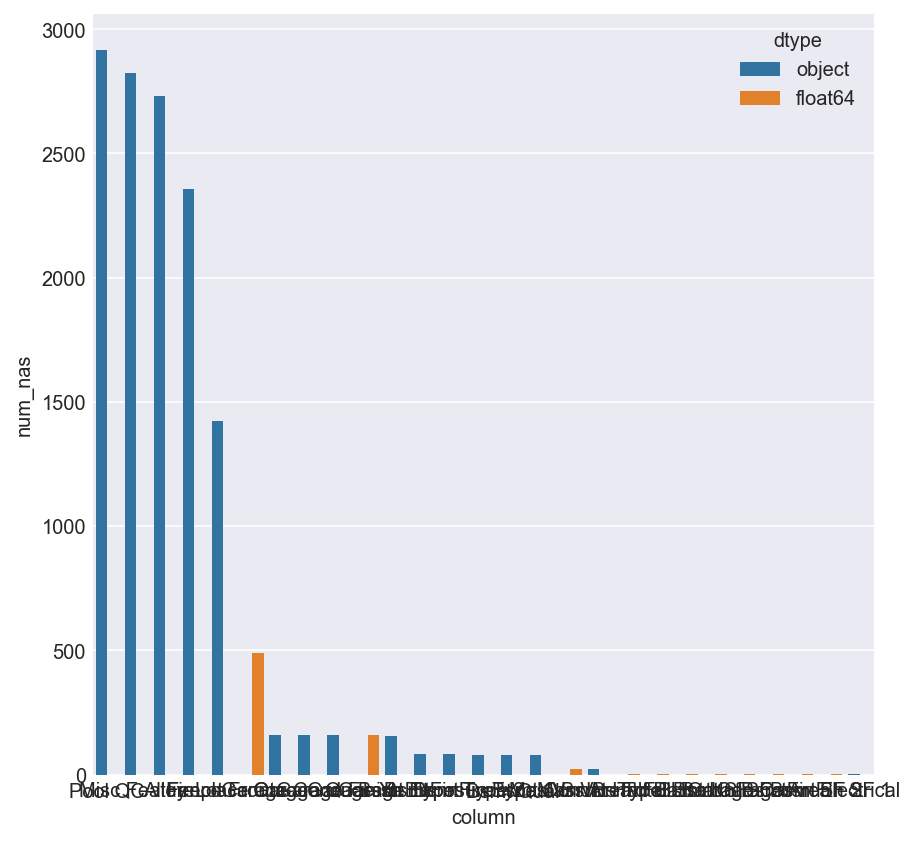

In [8]:
# Create barchart showing number of NaN values for each column

navalues = column_info[:-1][column_info["num_nas"]>0].sort_values("num_nas", ascending = False)

fig, ax = plt.subplots()
fig.set_size_inches(7, 7)

sns.barplot(data=navalues,ax=ax,x = "column", y = "num_nas", hue = "dtype");

In [9]:
# Create lists of column names to help create features

columns_to_dummy = column_info[column_info["make_dummy"] ==True]['column'].tolist()

columns_to_standardize = column_info[column_info["standardize"] ==True]['column'].tolist()

In [10]:
# Creating dummy columns and 2nd order polynomial interaction terms

all_data_dummies = all_data[columns_to_dummy]

all_data_dummies = pd.get_dummies(all_data_dummies, columns = all_data_dummies.columns, drop_first = True)

pf_dummy = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
pf_dummy = pf_dummy.fit(all_data_dummies)
all_data_dummies = pd.DataFrame(pf_dummy.transform(all_data_dummies), columns = pf_dummy.get_feature_names(all_data_dummies.columns))

In [11]:
#Creating 2nd order polymonial terms and interactions for numerical columns, then standardizing.

all_data_standard = all_data[columns_to_standardize]

pf_numeric = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
pf_numeric = pf_numeric.fit(all_data_standard)
all_data_standard = pd.DataFrame(pf_numeric.transform(all_data_standard), columns = pf_numeric.get_feature_names(all_data_standard.columns))

scaler = StandardScaler()

all_data_standard = pd.DataFrame(scaler.fit_transform(all_data_standard), columns = all_data_standard.columns)

In [12]:
all_data_standard.shape

(2930, 405)

In [13]:
all_data_dummies.shape

(2930, 38781)

In [14]:
#Bringing standardized and dummy columns into the same dataframe.

all_data = pd.concat([all_data[["Id", "SalePrice"]],all_data_standard, all_data_dummies], axis = 1)

In [15]:
all_data.shape

(2930, 39188)

In [16]:
# Create X_train, X_test, and y_train dataframes to be used in regression model.

X_train = all_data[all_data['Id'].isin(train_data["Id"].values.tolist())].drop("SalePrice", axis = 1)

X_test = all_data[all_data['Id'].isin(test_data["Id"].values.tolist())].drop("SalePrice", axis = 1)

y_train = all_data[all_data['Id'].isin(train_data["Id"].values.tolist())][["SalePrice"]]

In [17]:
X_train.shape

(2051, 39187)

In [18]:
X_test.shape

(879, 39187)

In [19]:
y_train.shape

(2051, 1)

In [20]:
#Create a dataframe with absolute value of correlation coefficents between each feature and SalePrice.
#Creating a list of 300 features based on the 300 highest correlation coefficients.

feature_names = X_train.columns.tolist()

corrcoefs = [abs(np.corrcoef(X_train[column], y_train["SalePrice"])[1,0]) for column in feature_names]

feature_corr = pd.DataFrame({"feature": feature_names, 
                            "abs(correlation to SalePrice)": corrcoefs})

features_to_include = feature_corr.sort_values("abs(correlation to SalePrice)", ascending = False).head(300)['feature'].values.tolist()

C:\Users\JW\Anaconda3\envs\dsi\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\JW\Anaconda3\envs\dsi\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [21]:
feature_corr.sort_values("abs(correlation to SalePrice)", ascending = False).head(20)

,feature,abs(correlation to SalePrice)
141,Overall Qual Gr Liv Area,0.837152
130,Overall Qual^2,0.825539
144,Overall Qual Garage Area,0.813247
131,Overall Qual Year Built,0.806902
132,Overall Qual Year Remod/Add,0.804740
5,Overall Qual,0.800207
142,Overall Qual TotRms AbvGrd,0.795420
138,Overall Qual 1st Flr SF,0.792151
137,Overall Qual Total Bsmt SF,0.768630
331,Gr Liv Area Garage Area,0.754659


In [22]:
# Redefining X_train and X_test to only include relevant features

X_train = X_train[features_to_include]

X_test = X_test[features_to_include]

In [23]:
# Fitting elastic net model to training data and scoring. 
#Experimenting with l1 ratios <1 produced worse results, so this is effectively the same as a LassoCV model

enet = linear_model.ElasticNetCV(l1_ratio = 1, random_state = 48, tol=0.0001, max_iter=10000, n_alphas=350)

model = enet.fit(X_train, y_train)

model.score(X_train, y_train)

C:\Users\JW\Anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9234531223408747

In [24]:
# Looking at coefficients and intercept of model

linear_coefs = pd.DataFrame({"feature": features_to_include, 
                            "linear_coef": model.coef_.tolist()})

linear_coefs[linear_coefs["linear_coef"] !=0].shape

print(model.intercept_)

linear_coefs["magnitude"] = abs(linear_coefs["linear_coef"])
linear_coefs.sort_values("magnitude", ascending = False)
linear_nonzero = linear_coefs[linear_coefs["linear_coef"] !=0]

linear_nonzero.sort_values("magnitude", ascending = False)

191545.24222825668


,feature,linear_coef,magnitude
0,Overall Qual Gr Liv Area,3.702670e+04,3.702670e+04
8,Overall Qual Total Bsmt SF,3.445434e+04,3.445434e+04
54,Exter Qual_TA,-2.191371e+04,2.191371e+04
105,Total Bsmt SF 1st Flr SF,-2.181223e+04,2.181223e+04
104,Mas Vnr Area Gr Liv Area,-2.011421e+04,2.011421e+04
129,Roof Style_Hip Garage Cars_3.0,1.781758e+04,1.781758e+04
259,Exter Qual_Gd Garage Cars_3.0,-1.718155e+04,1.718155e+04
7,Overall Qual 1st Flr SF,1.656464e+04,1.656464e+04
130,Half Bath_1 Garage Cars_3.0,1.650148e+04,1.650148e+04
244,Bsmt Qual_Ex Bsmt Exposure_Gd,1.629979e+04,1.629979e+04


In [25]:
# Cross validating model to check for outliers or over/underfittig

kf2 = KFold(n_splits=5, random_state=49, shuffle=True)

cvscores = cross_val_score(model, X_train, y_train, cv = kf2)

C:\Users\JW\Anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\JW\Anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\JW\Anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\JW\Anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1094: DataConversionWarning: A column-vector y 

In [26]:
np.mean(cvscores)

0.8803355389936554

In [27]:
mean_squared_error(model.predict(X_train),y_train)**.5


21923.231137223192

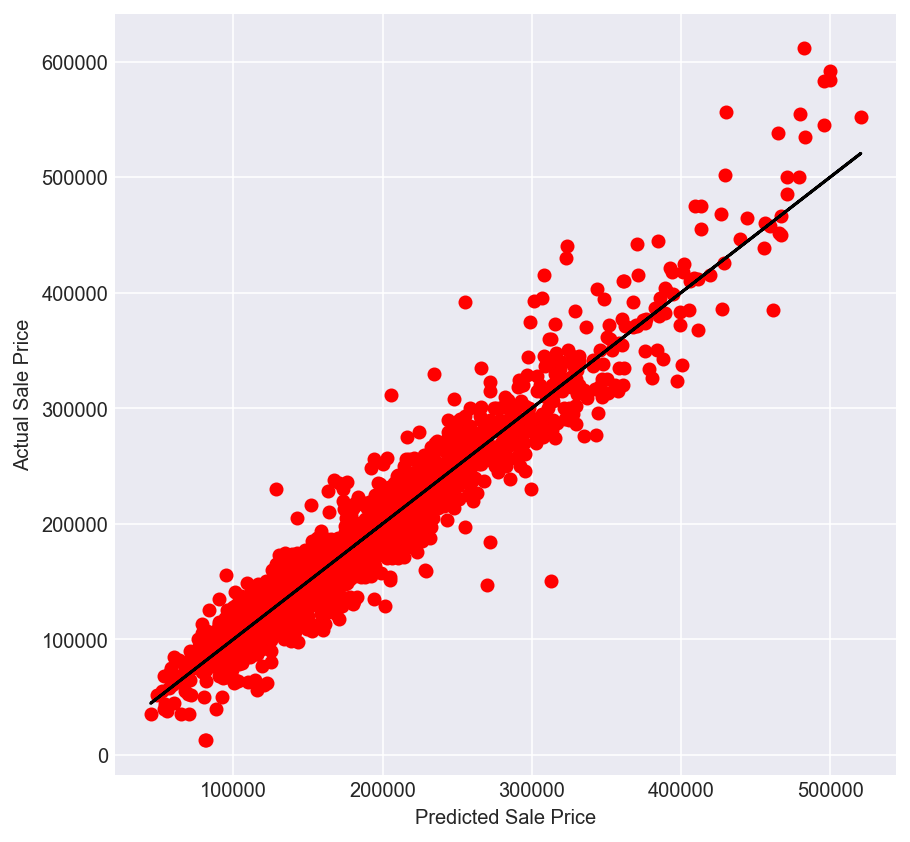

In [28]:
# Plotting predicted price vs actual price for training data.

fig = plt.figure(figsize=(7,7))
fig.set_figheight(7)
fig.set_figwidth(7)

ax = fig.gca()

plt.xlabel("Predicted Sale Price")
plt.ylabel("Actual Sale Price")
ax.scatter(x=model.predict(X_train), y=y_train, c='r')
ax.plot(model.predict(X_train), model.predict(X_train), color='k');

In [29]:
test_data.shape

(879, 80)

In [30]:
#Creating a dataframe of predicted prices for the test data, and saving as a csv file

solutions = all_data[all_data['Id'].isin(test_data["Id"].values.tolist())][["Id", "SalePrice"]]

solutions["SalePrice"] = pd.DataFrame(model.predict(X_test), index = solutions.index)

#solutions.to_csv("./solutions2.csv",index = False)